In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import matplotlib.pyplot as plt
from training.util import plot_losses, GaussWrapper
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training import toy

In [2]:
device = torch.device("cpu")

In [3]:
noise = torch.tensor(0.02).to(device) # 0.02
layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1))
]
learn_var = False
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

In [6]:
def plot_grid(dataset, testset, min, max, models, device):
    fig, axes = plt.subplots(nrows=4, ncols=len(models), figsize=(5 * len(models), 15))
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])
    results = []
    for i, (name, model, samples) in enumerate(models):
        plot_losses(name, model.all_losses(), axes[0, i])
        result = RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std)
        dataset.plot_predictions(min, max, model.infer, samples, axes[1, i], dataset=None, alpha = 0.1 if samples > 10 else 1)
        dataset.plot_predictions(min, max, model.infer, samples, axes[2, i], dataset=testset, alpha = 0.1 if samples > 10 else 1)
        plot_calibration(name, result, axes[3, i])
        results.append(result)

    return fig, results

In [18]:
from training.pp import PointPredictor
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.dropout import MonteCarloDropoutModule
from training.bbb import GaussianPrior, BBBModel
from training.gp import GaussianProcess

def train_models(dataset, batch_size):
    torch.manual_seed(42)
    trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size)


    torch.manual_seed(42)
    gp = GaussianProcess(dataset.normalized_xs, dataset.normalized_ys, noise / dataset.y_std**2)
    gp.train_model(100, report_every_epochs=-1)


    torch.manual_seed(42)
    pp = GaussWrapper(PointPredictor(layers), noise, learn_var)
    pp.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    swag_config = {
        "start_epoch": 70,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30
    }
    swag = GaussWrapper(SwagModel(layers, swag_config), noise, learn_var)
    swag.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    ensemble = Ensemble([GaussWrapper(PointPredictor(layers), noise, learn_var) for _ in range(5)])
    ensemble.train_model(100, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    mc_dropout = GaussWrapper(MonteCarloDropoutModule(layers, 0.1), noise, learn_var)
    mc_dropout.train_model(200, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    bbb = GaussWrapper(BBBModel(bbb_prior, "activations", layers, init="blundell"), noise, learn_var)
    bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.1)

    return [gp, pp, ensemble, swag, mc_dropout, bbb]

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4


C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


torch.Size([1000, 200, 1])


C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


torch.Size([1, 200, 1])
torch.Size([5, 200, 1])
torch.Size([1000, 200, 1])
torch.Size([1000, 200, 1])
torch.Size([1000, 200, 1])
| Simple Toy Regression   | Avg LML    | Mean MSE    | MSE of Means   | QCE        |
|-------------------------+------------+-------------+----------------+------------|
| Gaussian Process        | 1.02 ± nan | 0.001 ± nan | 0.000 ± nan    | 0.14 ± nan |
| MAP                     | 2.18 ± nan | 0.001 ± nan | 0.001 ± nan    | 0.32 ± nan |
| Ensemble-5              | 2.40 ± nan | 0.001 ± nan | 0.001 ± nan    | 0.30 ± nan |
| SWAG                    | 2.29 ± nan | 0.002 ± nan | 0.001 ± nan    | 0.25 ± nan |
| MC Dropout              | 1.90 ± nan | 0.003 ± nan | 0.001 ± nan    | 0.21 ± nan |
| Bayes By Backprop       | 2.10 ± nan | 0.002 ± nan | 0.001 ± nan    | 0.24 ± nan |


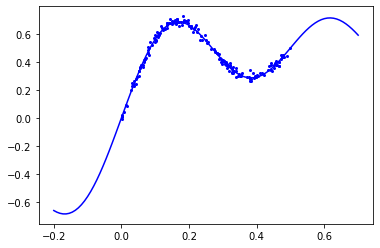

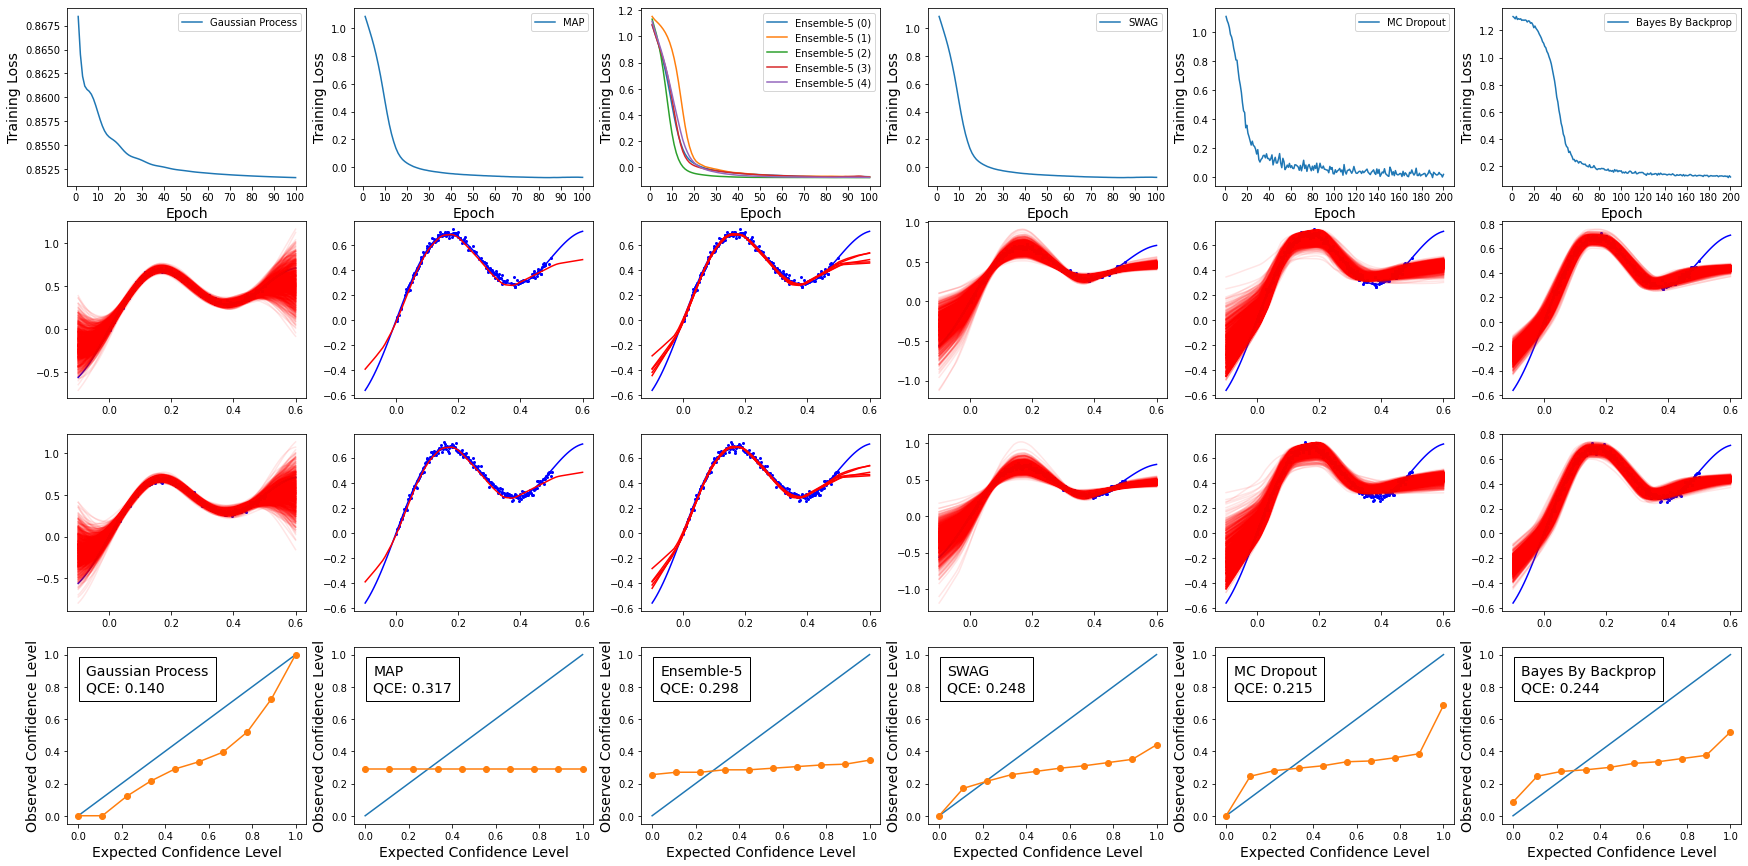

In [20]:
torch.manual_seed(42)
dataset = toy.TrigonometricToyDataset([(0, 0.5, 200)], noise)
dataset.plot_dataset(-0.2, 0.7, plt.subplot())

models = train_models(dataset, 20)

fig, results = plot_grid(dataset, dataset.generate_testset(0.0, 0.5, 200, noise), -0.1, 0.6, [
    ("Gaussian Process", models[0], 1000),
    ("MAP", models[1], 1),
    ("Ensemble-5", models[2], 5),
    ("SWAG", models[3], 1000),
    ("MC Dropout", models[4], 1000),
    ("Bayes By Backprop", models[5], 1000)
], device)

fig.savefig("results/toy/regression_simple.png")

plot_table("Simple Toy Regression", [[result] for result in results], "results/toy/regression_simple.txt")

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4


C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\U

| Gap Toy Regression   | Avg LML     | Mean MSE    | MSE of Means   | QCE        |
|----------------------+-------------+-------------+----------------+------------|
| Gaussian Process     | 1.01 ± nan  | 0.010 ± nan | 0.002 ± nan    | 0.08 ± nan |
| MAP                  | -0.40 ± nan | 0.003 ± nan | 0.003 ± nan    | 0.28 ± nan |
| Ensemble-5           | -0.40 ± nan | 0.005 ± nan | 0.004 ± nan    | 0.24 ± nan |
| SWAG                 | 1.30 ± nan  | 0.004 ± nan | 0.003 ± nan    | 0.15 ± nan |
| MC Dropout           | 1.82 ± nan  | 0.004 ± nan | 0.002 ± nan    | 0.15 ± nan |
| Bayes By Backprop    | 0.30 ± nan  | 0.004 ± nan | 0.004 ± nan    | 0.17 ± nan |


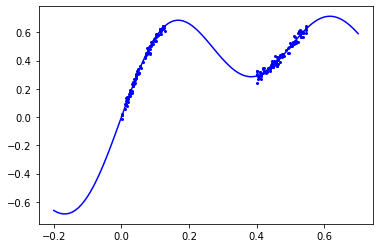

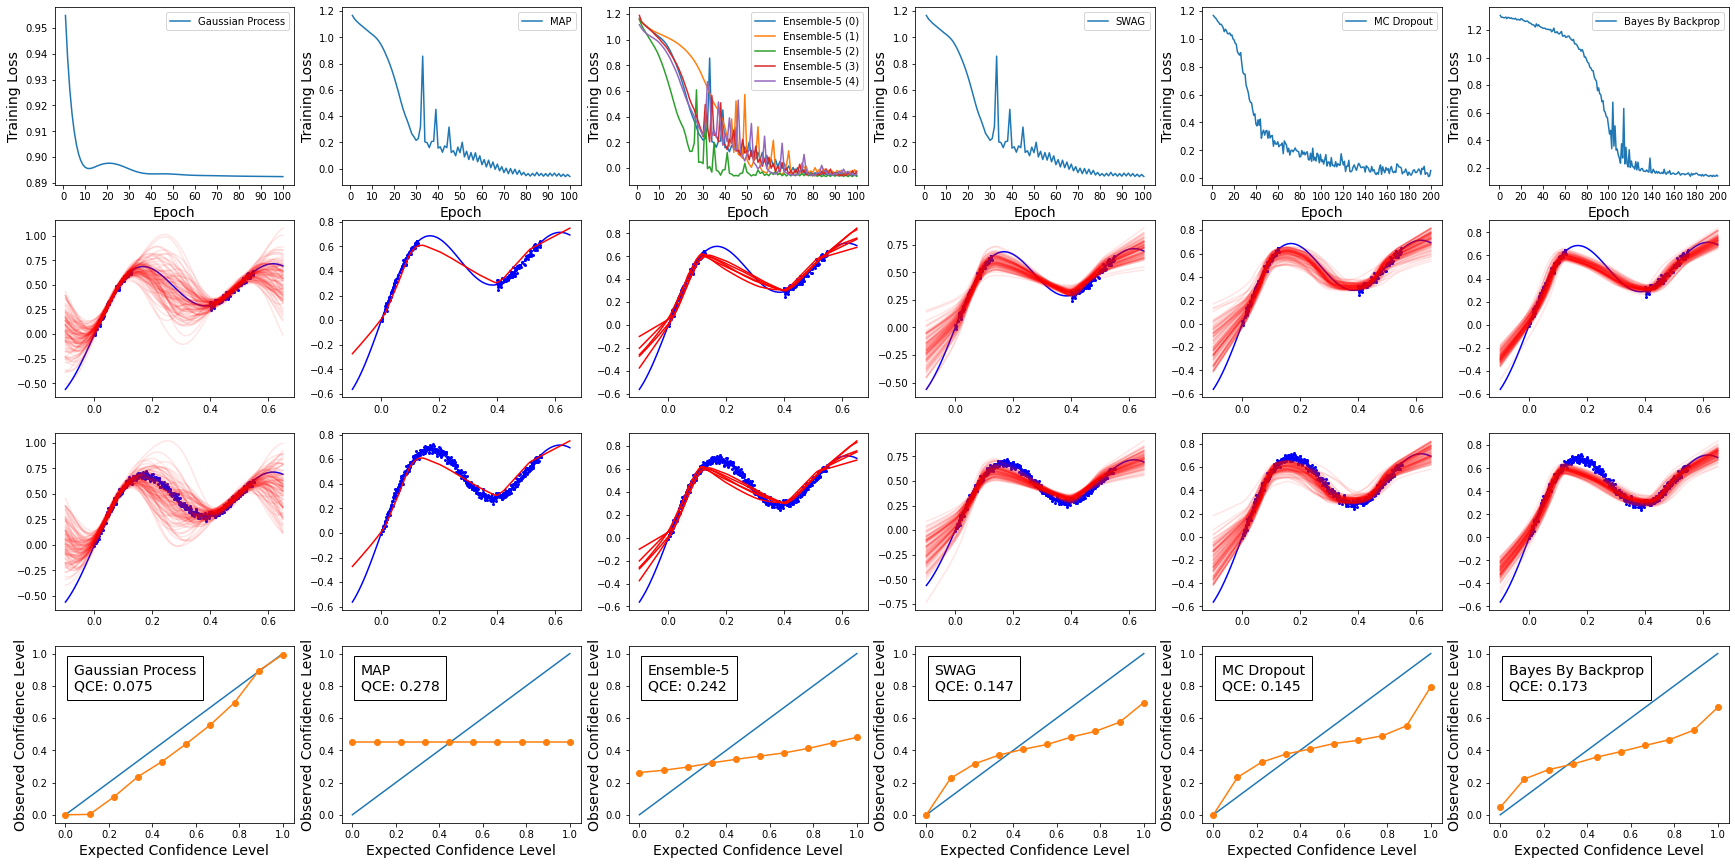

In [21]:
torch.manual_seed(42)
dataset = toy.TrigonometricToyDataset([(0, 0.13, 100), (0.4, 0.55, 100)], noise)
dataset.plot_dataset(-0.2, 0.7, plt.subplot())

models = train_models(dataset, 20)

fig, results = plot_grid(dataset, dataset.generate_testset(0.0, 0.55, 500, noise), -0.1, 0.65, [
    ("Gaussian Process", models[0], 100),
    ("MAP", models[1], 1),
    ("Ensemble-5", models[2], 5),
    ("SWAG", models[3], 100),
    ("MC Dropout", models[4], 100),
    ("Bayes By Backprop", models[5], 100)
], device)

fig.savefig("results/toy/regression_gap.png")

plot_table("Gap Toy Regression", [[result] for result in results], "results/toy/regression_gap.txt")